In [1]:
import os
import re
import string
import random
import pandas as pd
import operator
import matplotlib.pylab as plt
import warnings
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from nltk.tokenize import word_tokenize

warnings.filterwarnings(action="ignore")
%matplotlib inline

Создадим несколько переменных для того, чтобы составить материальню базу.

**folds** – Это список папок, в которых хранятся наши тектсы, с которыми мы будем работать.

**txts** – Список, в который мы поместим все наши тексты после обработки.

**dir_line** – путь до нашей рабочей директори

In [2]:
folds = ['Friends - season 1', 'Friends - season 2', 'Friends - season 3',
         'Friends - season 4', 'Friends - season 5', 'Friends - season 6',
         'Friends - season 7']

txts = []

dir_line = '/Users/macbook/Downloads/Friends/'

Добавим функцию, которая будет чистить текст от всякой гадости.

    1.Для очистки от знаков использую *string.punctuation*

    2.Помимо этого в тексте есть и другия грязь, от которой необходимо избавиться.

    3.Выполняю токенизацию текста и склеиваю все в один текст, *исключая числа*.

In [3]:
def cleaning(text):
    tokens = word_tokenize(text.lower())
    for el in tokens:
        if el in string.punctuation:
            tokens.remove(el)
        if el == '...' or el == "''" or el == '—' or el == '«' or el == '»':
            tokens.remove(el)
    text = ' '.join([i for i in tokens if not i.isdigit()])
    return(text)

Пройдемся по папкам и достанем все текста. Обработаем его и добавим в список.

In [4]:
for fold in folds:
    local_dir = list(os.walk(dir_line + fold))
    local_path = str(local_dir[0][0])
    for text in local_dir[0][2]:
        if '.txt' in text and type(text) == str:
            with open(local_path + '/' + text) as file:
                txts.append(cleaning(file.read()))

Для составления терм-документ матрицы я использую ***CountVectorizer*** из *sklearn.feature_extraction.text*

Тем самым составлю матрицу, где:

    Столбцы – Это слова
    Строки – Это документы

Для удобства также преобразую матрицу в **DataFrame** при помощи Pandas

In [5]:
vec = CountVectorizer()
TDM = vec.fit_transform(txts).toarray()
TDM_DataFrame = pd.DataFrame(TDM,
                             columns=vec.get_feature_names())

In [6]:
TDM_DataFrame.shape

(165, 30829)

Получается 165 документов и 30829 слов.

Напишем простую функцию Булева поиска, которая может искать только одно слово.

Как я и говорил раньше, всвязи с форматом матрицы, необходимо только найти такие строки, в столбце соответсвующем патерну поиска стоит НЕ ноль.

In [7]:
def boolean_search(pattern):
    try:
        return TDM_DataFrame[TDM_DataFrame[pattern.lower()] != 0].index.tolist()
    except KeyError:
        return 'No pattern in DataSet'

In [8]:
boolean_search('Рейчел')

[22,
 24,
 25,
 27,
 29,
 30,
 32,
 33,
 34,
 35,
 40,
 42,
 44,
 45,
 46,
 49,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 68,
 70,
 71,
 72,
 73,
 75,
 76,
 77,
 79,
 80,
 81,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 116,
 117,
 123,
 126,
 127,
 128,
 129,
 130,
 131,
 133,
 134,
 139,
 140,
 150,
 151,
 152,
 155,
 157,
 158,
 159,
 160,
 161,
 163]

In [9]:
boolean_search('Фиби')

[0,
 2,
 3,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 31,
 32,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 53,
 54,
 55,
 56,
 58,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 81,
 83,
 85,
 86,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 110,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 120,
 121,
 122,
 123,
 124,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 158,
 159,
 160,
 161,
 162,
 163,
 164]

Вроде работает. Теперь займемся более сложным поиском.

Лоя этого, сперва напишем две фенкции, которые помогут нам взаимодействовать со строкой с параметрами поиска. Для этого нам необходимо.
    
    Вычетание списков "Для (Не pattern)" – Difference(line)
    Сумма списков "Для (pattern ИЛИ pattern)" – Union(line)
    
В этих функциях, я достаю слова, которые нам нобходжимо дость из файлов, нахожу список файлов, в которых встречаются эти слова, а затем выполняю необходимые мне файлы.

Для Вычетания применяю такой алгоритм:

    1. Получаю файлы ГДЕ ВСТРЕЧАЕТСЯ необходимое слово.
    2. Создаю список range от 1 до 165
    3. Вычитаю из списка (п.2) список (п.1), тем самым получаю файлы, в которых нет необходимого слова.
    

In [10]:
def Union(line):
    try:
        sub = re.search('\((.*?) ИЛИ (.*?)\)', line)
        result_1 = boolean_search(str(sub.group(1)))
        result_2 = boolean_search(str(sub.group(2)))
        return list(set.union(set(result_1),
                              set(result_2)))
    except AttributeError:
        return None
        
def Difference(line):
    try:
        sub = re.search('\(НЕ (.*?)\)', line)
        result_1 = boolean_search(str(sub.group(1)).lower())
        return list(set.difference(set(range(1, TDM_DataFrame.shape[0])), set(result_1)))
    except AttributeError:
        return None

Основная функция поиска. Если в строке втречается необходимая мне фраза ("ИЛИ" или "НЕ"), то выполняю необходимую фунуцию для получения номеров файлов.

In [11]:
def boolean_search_type_r(pattern):
    try:
        local_pattern = pattern.split(' & ')
        local_result = []
        for el in local_pattern:
            if ' ИЛИ ' in el:
                local_result.append(Union(el))
            elif 'НЕ ' in el:
                local_result.append(Difference(el))
            else:
                local_result.append(boolean_search(el))
        return list(set.intersection(*map(set, local_result)))
    except KeyError:
        return 'No pattern in DataSet'

**Проверим работу нашего алгоритма**

In [12]:
print(boolean_search_type_r('(НЕ Моника)'))

[128, 129, 131, 134, 135, 9, 12, 142, 15, 78, 81, 82, 19, 84, 149, 85, 87, 89, 158, 32, 97, 39, 48, 50, 115, 55, 58]


In [13]:
print(boolean_search_type_r('(машина ИЛИ консоль)'))

[4, 135, 137, 10, 17, 148, 153, 154, 162, 35, 39, 42, 107, 111, 51, 116, 120, 61, 126]


In [14]:
boolean_search_type_r('консоль')

[126]

In [15]:
boolean_search_type_r('машина')

[4,
 135,
 137,
 10,
 17,
 148,
 153,
 154,
 162,
 35,
 39,
 42,
 107,
 111,
 51,
 116,
 120,
 61]

_________



In [16]:
result = defaultdict()

def sharp_cleaning(text):
    tokens = word_tokenize(text.lower())
    for el in tokens:
        if el in string.punctuation:
            tokens.remove(el)
        if el == '...' or el == "''" or el == '—' or el == '«' or el == '»':
            tokens.remove(el)
    return(list([i for i in tokens if not i.isdigit()]))

In [17]:
result = defaultdict()

for fold in folds:
    local_dir = list(os.walk(dir_line + fold))
    local_path = str(local_dir[0][0])
    for text in local_dir[0][2]:
        if '.txt' in text and type(text) == str:
            with open(local_path + '/' + text) as file:
                local_text = sharp_cleaning(file.read())
                index = text.split(' - ')[1]
                for word in local_text:
                    if word in result:
                        if index in list(chain(*result[word])):
                            num = list(chain(*result[word])).index(index) // 2
                            result[word][num][1] += 1
                        else:
                            result[word].append([index, 1])
                    else:
                        result[word] = [[index, 1]]

In [18]:
result

defaultdict(None,
            {'трынди': [['7x19', 1]],
             'гитаре': [['2x13', 1], ['2x23', 1], ['5x11', 3]],
             'бывшие': [['2x07', 1]],
             'выбрасывать': [['3x01', 1], ['6x08', 1]],
             'воду': [['1x08', 1],
              ['2x12', 1],
              ['4x15', 1],
              ['4x22', 1],
              ['6x23', 1]],
             'кофе': [['1x01', 6],
              ['1x03', 1],
              ['1x04', 1],
              ['1x09', 1],
              ['1x12', 1],
              ['1x16', 3],
              ['1x18', 1],
              ['1x19', 2],
              ['2x01', 2],
              ['2x02', 2],
              ['2x10', 2],
              ['2x11', 2],
              ['2x12', 1],
              ['2x13', 1],
              ['2x17', 1],
              ['2x19', 1],
              ['2x21', 4],
              ['2x22', 1],
              ['2x23', 1],
              ['2x24', 1],
              ['3x03', 1],
              ['3x05', 3],
              ['3x06', 2],
             

In [19]:
result['рейчел']

[['2x02', 3],
 ['2x04', 1],
 ['2x05', 1],
 ['2x07', 3],
 ['2x09', 2],
 ['2x10', 5],
 ['2x12', 2],
 ['2x13', 3],
 ['2x14', 8],
 ['2x15', 2],
 ['2x20', 1],
 ['2x22', 13],
 ['2x24', 7],
 ['3x01', 3],
 ['3x02', 4],
 ['3x05', 2],
 ['3x07', 2],
 ['3x08', 4],
 ['3x10', 2],
 ['3x11', 3],
 ['3x12', 6],
 ['3x13', 2],
 ['3x14', 1],
 ['3x15', 2],
 ['3x16', 11],
 ['3x17', 15],
 ['3x18', 2],
 ['3x19', 2],
 ['3x20', 6],
 ['3x21', 5],
 ['4x01', 5],
 ['4x02', 4],
 ['4x03', 3],
 ['4x04', 4],
 ['4x05', 3],
 ['4x06', 1],
 ['4x08', 4],
 ['4x09', 3],
 ['4x10', 6],
 ['4x12', 5],
 ['4x13', 9],
 ['4x14', 9],
 ['4x16', 2],
 ['4x17', 1],
 ['4x18', 2],
 ['4x19', 2],
 ['4x20', 3],
 ['4x21', 8],
 ['4x22', 2],
 ['4x23-24', 11],
 ['4x24-25', 7],
 ['5x01', 5],
 ['5x02', 15],
 ['5x03', 2],
 ['5x04', 6],
 ['5x05', 9],
 ['5x06', 9],
 ['5x07', 1],
 ['5x08', 6],
 ['5x09', 6],
 ['5x10', 3],
 ['5x11', 5],
 ['5x12', 5],
 ['5x13', 2],
 ['5x14', 3],
 ['5x15', 1],
 ['5x16', 1],
 ['5x17', 4],
 ['5x18', 7],
 ['5x19', 2],
 ['6x01',

In [20]:
def max_word(diction):
    local_diction = defaultdict()
    for word in diction:
        local_diction[word] = sum(filter(lambda i: isinstance(i, int), list(chain(*diction[word]))))
    return max(local_diction, key=local_diction.get)

def min_word(diction):
    local_diction = defaultdict()
    for word in diction:
        local_diction[word] = sum(filter(lambda i: isinstance(i, int), list(chain(*diction[word]))))
    return min(local_diction, key=local_diction.get)

In [21]:
min_word(result)

'трынди'

In [22]:
max_word(result)

'я'

In [23]:
for word in result:
    if len(result[word]) == 165:
        print(word)

In [24]:
def most_season(dude):
    local_result = {}
    data = result[dude.lower()]
    for el in data:
        if el[0].split('x')[0] in local_result:
            local_result[el[0].split('x')[0]] += el[1]
        else:
            local_result[el[0].split('x')[0]] = 1
    return local_result

In [25]:
def converting(dictionary):
    result = [0, 0, 0, 0, 0, 0, 0]
    for el in dictionary:
        result[int(el) - 1] = dictionary[el]
    return result

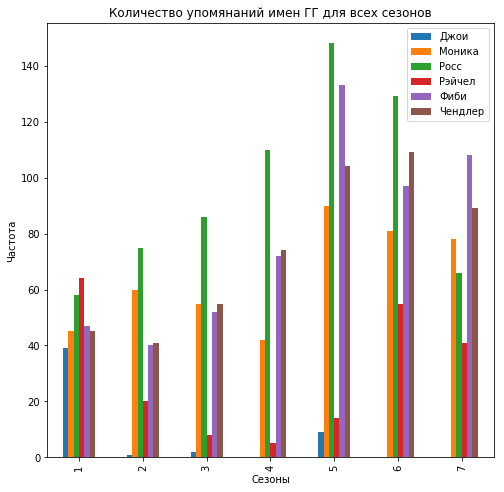

In [26]:
percentile_list = pd.DataFrame(
    {'Росс': converting(most_season('Росс')),
     'Джои': converting(most_season('Джои')),
     'Рэйчел': converting(most_season('Рэйчел')),
     'Фиби': converting(most_season('Фиби')),
     'Моника': converting(most_season('Моника')),
     'Чендлер': converting(most_season('Чендлер')),
    })

percentile_list.index += 1
percentile_list.plot.bar(figsize=(8, 8),
                         title='Количество упомянаний имен ГГ для всех сезонов',
                         legend=True)

plt.xlabel('Сезоны')
plt.ylabel('Частота')

____________

# Okapi25

Сперва, для решения этой задачи реализуем функцию, которую мы видели на семинаре с соответствующими переменными

In [27]:
from math import log

k1 = 2.0
b = 0.75

def score_BM25(qf, dl, avgdl, k1, b, N, n) -> float:
    IDF = log(((N - n + 0.5) / (n + 0.5)))
    first = (k1 + 1) * qf
    second = qf + (k1 * ((1-b) + b * (float(dl)/float(avgdl))))
    return IDF * (first / second)

Проверим работоспособность нашей функции на примере рандомных чисел.

In [28]:
score_BM25(1, 2, 14, k1, b, 3, 2)

-0.8939448415904836

Не ломается и хорошо...

Теперь, составим новый формат хранения данных, это нам поможет для осуществления быстрой работы ранжирования при дальнейшей работы алгоритма.

Сперва предствим нашу коллекцию ввиде словаря, где:

    Ключи – Название документа
    Значения – Список, который содержит частотный словарь для текста и количетсво слов.

In [29]:
folds = ['Friends - season 1', 'Friends - season 2', 'Friends - season 3',
         'Friends - season 4', 'Friends - season 5', 'Friends - season 6',
         'Friends - season 7']

documents = defaultdict()

dir_line = '/Users/macbook/Downloads/Friends/'

for fold in folds:
    local_dir = list(os.walk(dir_line + fold))
    local_path = str(local_dir[0][0])
    for text in local_dir[0][2]:
        if '.txt' in text and type(text) == str:
            with open(local_path + '/' + text) as file:
                text_list, text_data = sharp_cleaning(file.read()), defaultdict()
                for word in text_list:
                    if not word in text_data:
                        text_data[word] = 0
                    text_data[word] += 1
                documents[str(text)] = [text_data, len(text_list)]

Выведем данные для рандомного текста нашей коллекции.

In [30]:
documents[random.choice(list(documents.keys()))]

[defaultdict(None,
             {'!': 2,
              "''": 1,
              '-': 105,
              '--': 1,
              '.': 5,
              '...': 16,
              '00:00:0,500': 1,
              '00:00:2,00': 1,
              '8.00': 1,
              '94.': 1,
              '?': 2,
              '``': 12,
              'gap': 1,
              'khakis': 1,
              'swing': 1,
              'www.tvsubtitles.net': 1,
              'а': 26,
              'ах-ах-ах': 1,
              'баксов': 2,
              'банкет': 1,
              'бегу': 1,
              'бейли': 1,
              'бен': 1,
              'бистро': 1,
              'близкий': 1,
              'боже': 2,
              'больше': 2,
              'брак': 1,
              'братан': 1,
              'бруклин': 2,
              'будем': 1,
              'будет': 5,
              'будешь': 1,
              'будь': 2,
              'бумаги': 1,
              'бутике': 1,
              'бы': 11,
              'бы

Чтобы получить количество текстов в коллекции, просто надо посмотреть на длинну нашего словаря

In [31]:
len(documents)

165

Чтобы посчитать среднюю длинну тектов коллекции, сложим все данные для каждого текста и поделим на длинну списка с длиннами.

In [32]:
def mean_doc_len(coll):
    result = []
    for doc in coll:
        result.append(int(coll[doc][1]))
    return sum(result) / float(len(result))

In [33]:
mean_doc_len(documents)

2023.7575757575758

Также для работы нашей формулы нам необходимо найти количество документов, где встречается слово из запроса.

In [34]:
def query_occurrence(query, coll):
    result = 0
    for doc in coll:
        if query.lower() in coll[doc][0]:
            result += 1
    return result

In [35]:
query_occurrence('Рэйчел', documents)

56

Теперь все готово к работе с нашей формулой!

In [78]:
def compute_sim(query, document):
    result = defaultdict()
    N = len(documents)
    avgdl = mean_doc_len(documents)
    k1 = 2.0
    b = 0.75
    n = query_occurrence(query, documents)
    dl = document[1]
    try:
        qf = document[0][str(query).lower()]
    except KeyError:
        qf = 0
    return score_BM25(qf, dl, avgdl, k1, b, N, n)


def get_search_result(query) -> list:
    result = {}
    words = query.split(' ')
    for document in documents:
        local_score = 0
        for word in words:
            local_score += compute_sim(word, documents[document])
        result[str(document)] = local_score
    return result


In [81]:
get_search_result('рождественские каникулы')

{'Friends - 1x01 - The One Where Monica Gets A Roommate.ru.txt': 0.0,
 'Friends - 1x02 - The One With The Sonogram At The End.ru.txt': 0.0,
 'Friends - 1x03 - The One With The Thumb.ru.txt': 0.0,
 'Friends - 1x04 - The One With George Stephanopoulos.ru.txt': 0.0,
 'Friends - 1x05 - The One With The East German Laundry Detergent.ru.txt': 0.0,
 'Friends - 1x06 - The One With The Butt.ru.txt': 0.0,
 'Friends - 1x07 - The One With The Blackout.ru.txt': 0.0,
 'Friends - 1x08 - The One Where Nana Dies Twice.ru.txt': 0.0,
 'Friends - 1x09 - The One Where Underdog Gets Away.ru.txt': 0.0,
 'Friends - 1x10 - The One With The Monkey.ru.txt': 0.0,
 'Friends - 1x11 - The One With Mrs. Bing.ru.txt': 0.0,
 'Friends - 1x12 - The One With The Dozen Lasagnas.ru.txt': 0.0,
 'Friends - 1x13 - The One With The Boobies.ru.txt': 0.0,
 'Friends - 1x14 - The One With The Candy Hearts.ru.txt': 0.0,
 'Friends - 1x15 - The One With The Stoned Guy.ru.txt': 0.0,
 'Friends - 1x16 - The One With Two Parts (1).ru.txt'

In [72]:
compute_sim('каникулы', documents[random.choice(list(documents.keys()))])

0.0